## Plotting with MCMCChains.jl's `Chains` objects produced by Turing.jl

In [1]:
using Random
Random.seed!(42)

using ArviZ

# use fancy HTML for xarray.Dataset if available
try
    ArviZ.xarray.set_options(display_style = "html")
catch
    nothing
end

# ArviZ ships with style sheets!
ArviZ.use_style("arviz-darkgrid")

ArviZ is designed to work well with high dimensional, labelled data.
Consider the [eight schools model](https://statmodeling.stat.columbia.edu/2014/01/21/everything-need-know-bayesian-statistics-learned-eight-schools/), which roughly tries to measure the effectiveness of SAT classes at eight different schools.
To show off ArviZ's labelling, I give the schools the names of [a different eight schools](https://en.wikipedia.org/wiki/Eight_Schools_Association).

This model is small enough to write down, is hierarchical, and uses labelling.
Additionally, a centered parameterization causes [divergences](https://mc-stan.org/users/documentation/case-studies/divergences_and_bias.html) (which are interesting for illustration).

First we create our data and set some sampling parameters.

In [2]:
J = 8
y = [28.0, 8.0, -3.0, 7.0, -1.0, 1.0, 18.0, 12.0]
σ = [15.0, 10.0, 16.0, 11.0, 9.0, 11.0, 10.0, 18.0]
schools = [
    "Choate",
    "Deerfield",
    "Phillips Andover",
    "Phillips Exeter",
    "Hotchkiss",
    "Lawrenceville",
    "St. Paul's",
    "Mt. Hermon"
]

nwarmup, nsamples, nchains = 1000, 1000, 4;

Now we write and run the model using Turing:

In [3]:
using Turing

Turing.@model turing_model(J, y, σ) = begin
    μ ~ Normal(0, 5)
    τ ~ truncated(Cauchy(0, 5), 0, Inf)
    θ ~ MvNormal(μ .* ones(J), τ .* ones(J))
    y ~ MvNormal(θ, σ)
end

param_mod = turing_model(J, y, σ)
sampler = NUTS(nwarmup, 0.8)
turing_chns = psample(
    param_mod,
    sampler,
    nwarmup + nsamples,
    nchains;
    progress = false,
);

┌ Info: Found initial step size
│   ϵ = 0.4
└ @ Turing.Inference /Users/saxen/.julia/packages/Turing/LONxt/src/inference/hmc.jl:550


Most ArviZ functions work fine with `Chains` objects from Turing:

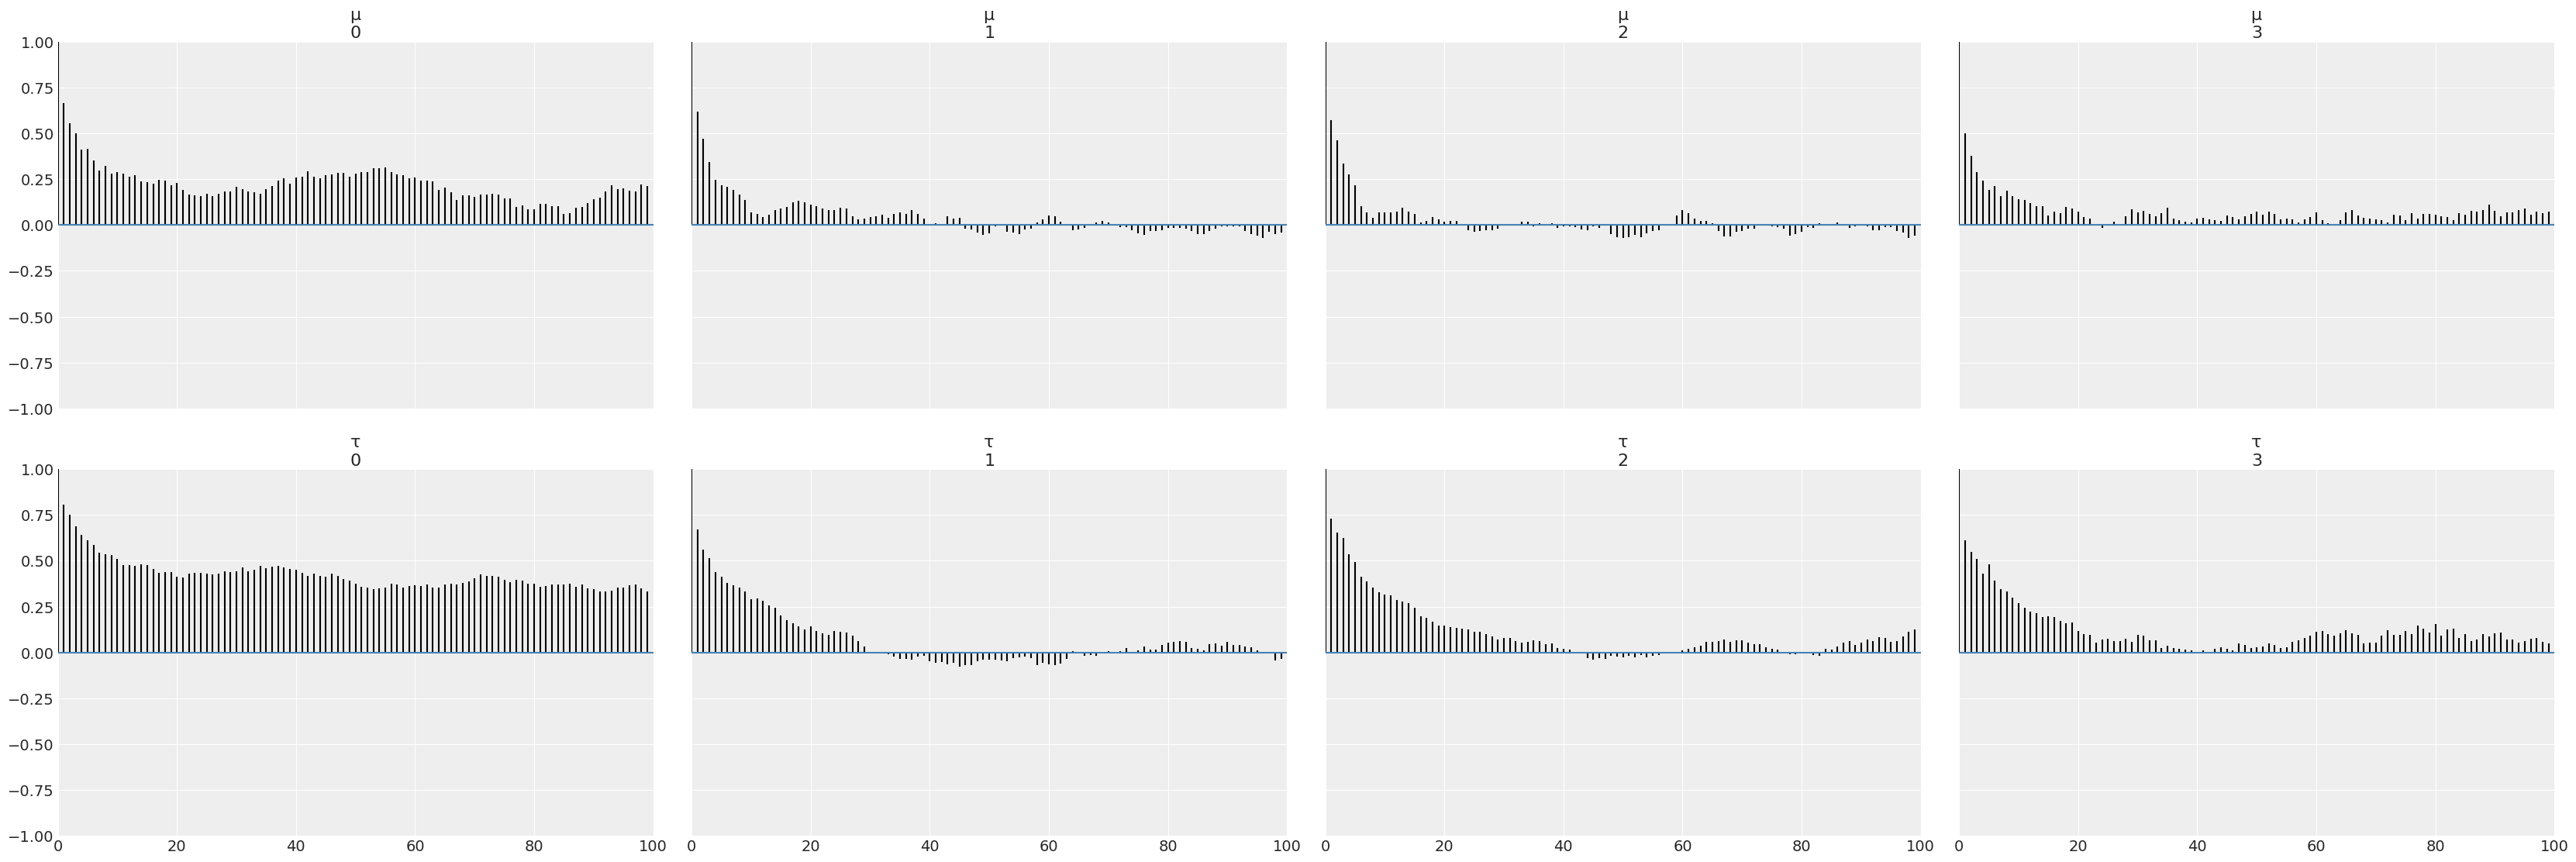

In [4]:
plot_autocorr(convert_to_inference_data(turing_chns); var_names = ["μ", "τ"]);

### Convert to `InferenceData`

For much more powerful querying, analysis and plotting, we can use built-in ArviZ utilities to convert `Chains` objects to xarray datasets.
Note we are also giving some information about labelling.

ArviZ is built to work with `InferenceData` (a netcdf datastore that loads data into `xarray` datasets), and the more *groups* it has access to, the more powerful analyses it can perform.

In [5]:
idata = from_mcmcchains(
    turing_chns,
    coords = Dict("school" => schools),
    dims = Dict(
        "y" => ["school"],
        "σ" => ["school"],
        "θ" => ["school"],
    ),
    library = "Turing",
)

InferenceData with groups:
	> posterior
	> sample_stats

Each group is an `ArviZ.Dataset` (a thinly wrapped `xarray.Dataset`).
We can view a summary of the dataset.

In [6]:
idata.posterior

Dataset (xarray.Dataset)
Dimensions:  (chain: 4, draw: 1000, school: 8)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
  * school   (school) <U16 'Choate' 'Deerfield' ... "St. Paul's" 'Mt. Hermon'
Data variables:
    μ        (chain, draw) float64 8.008 8.008 8.008 8.008 ... 6.105 6.105 6.105
    τ        (chain, draw) float64 0.1654 0.1654 0.1654 ... 1.097 1.097 1.097
    θ        (chain, draw, school) float64 8.385 8.149 7.976 ... 7.379 5.877
Attributes:
    created_at:         2020-02-10T01:27:29.022175
    vi:                 <PyCall.jlwrap DynamicPPL.VarInfo{NamedTuple{(:μ, :τ,...
    spl:                <PyCall.jlwrap DynamicPPL.Sampler{NUTS{Turing.Core.Fo...
    range:              <PyCall.jlwrap MersenneTwister(UInt32[0x3fe1d8bf, 0x4...
    model:              <PyCall.jlwrap DynamicPPL.Model{var"##inner_function#...
    inference_library:  Turing

Here is a plot of the trace. Note the intelligent labels.

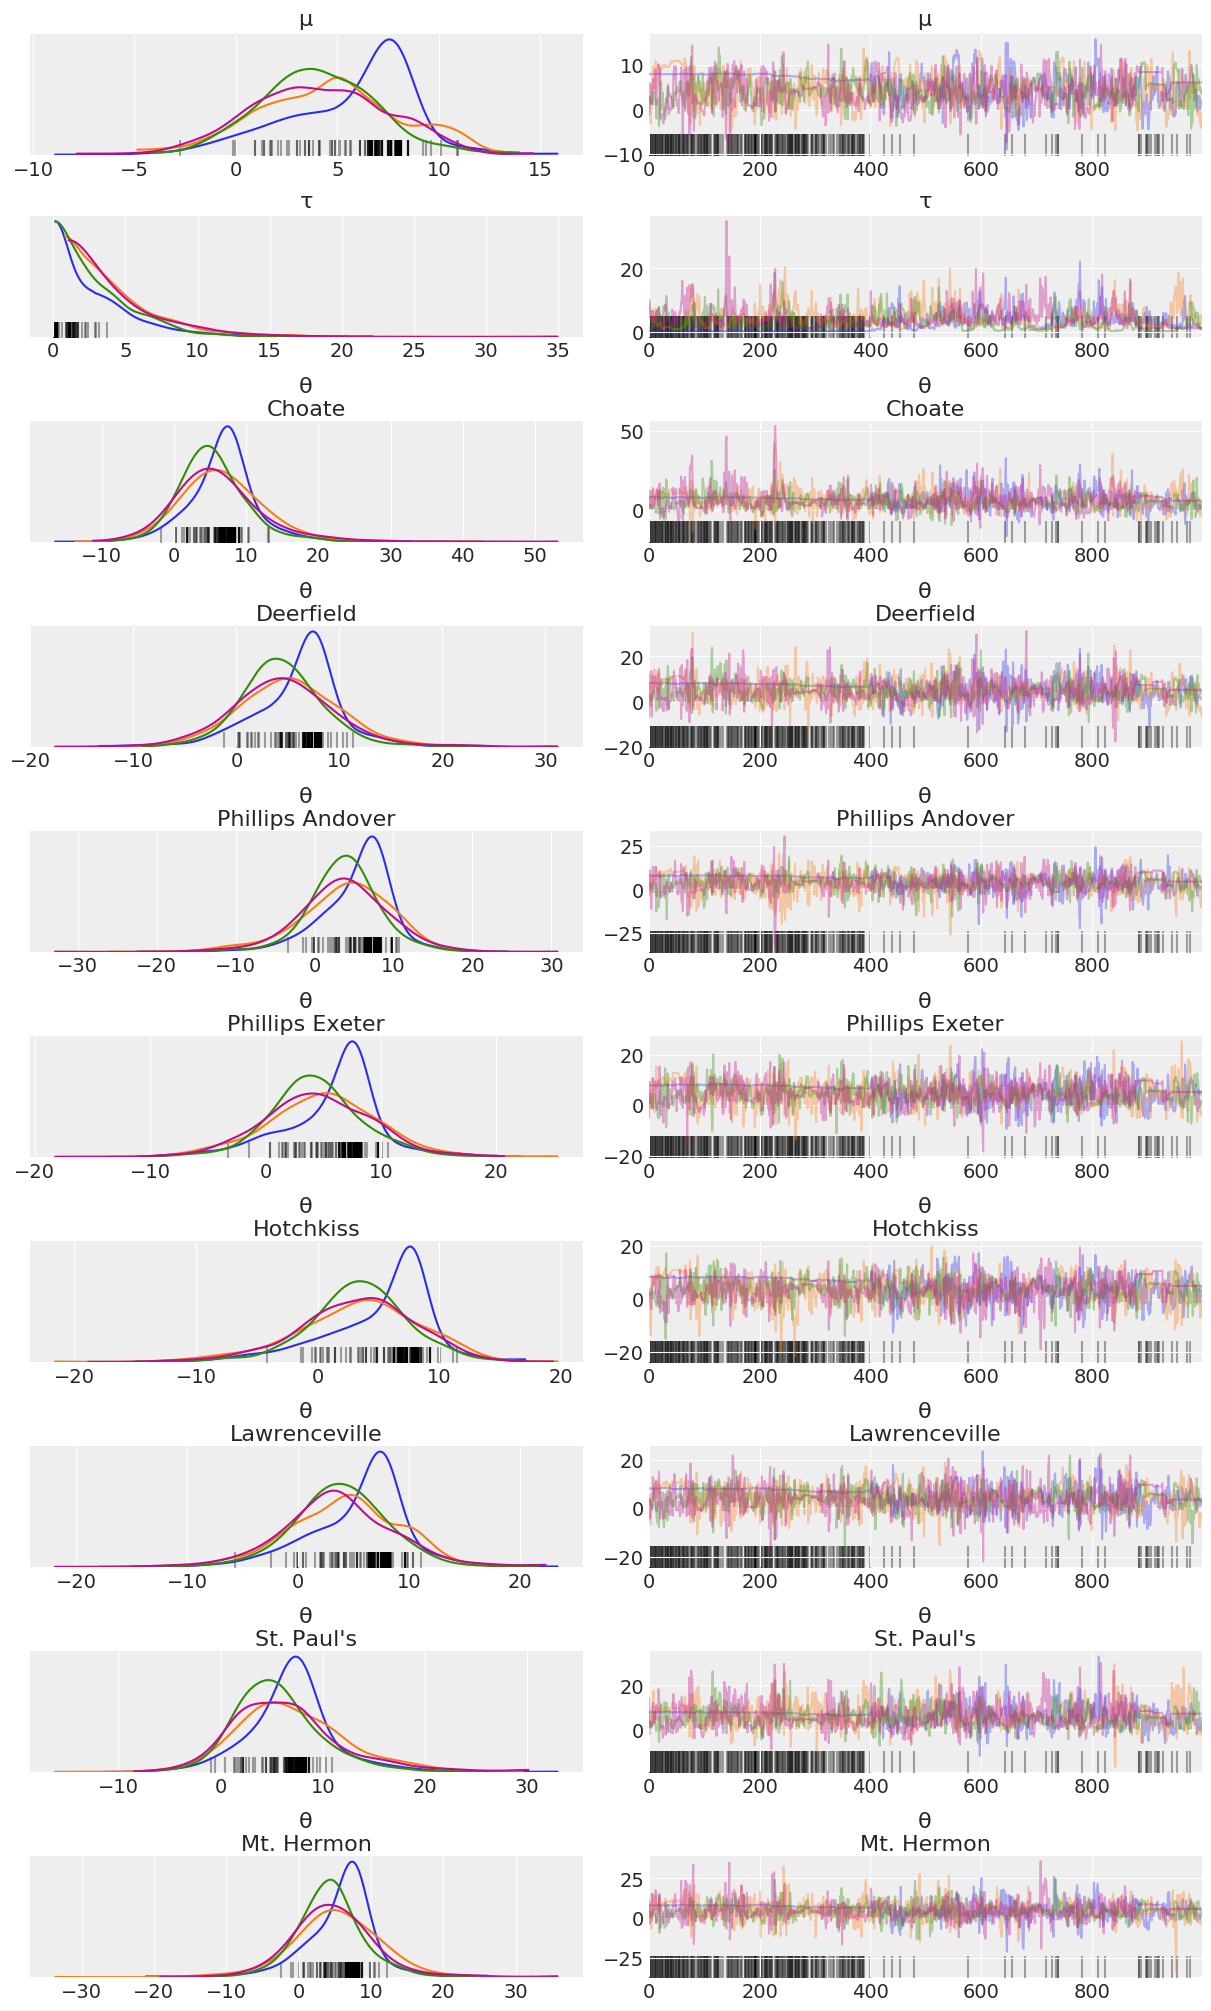

In [7]:
plot_trace(idata);

We can also generate summary stats

In [8]:
summarystats(idata)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
μ,4.611,3.316,-1.266,10.949,0.423,0.301,61.0,61.0,66.0,410.0,1.05
τ,3.471,3.139,0.133,9.039,0.561,0.401,31.0,31.0,13.0,16.0,1.24
θ[1],6.348,5.503,-4.336,16.156,0.213,0.150,670.0,670.0,541.0,1159.0,1.03
θ[2],5.095,4.633,-4.152,13.372,0.204,0.145,514.0,514.0,278.0,1174.0,1.02
θ[3],4.139,5.247,-5.846,13.737,0.326,0.231,259.0,259.0,152.0,853.0,1.03
θ[4],4.922,4.497,-4.079,12.908,0.262,0.185,295.0,295.0,227.0,1604.0,1.02
θ[5],3.812,4.672,-5.385,12.092,0.449,0.318,108.0,108.0,88.0,896.0,1.04
θ[6],4.299,4.720,-4.694,12.870,0.406,0.288,135.0,135.0,126.0,1621.0,1.03
θ[7],6.497,4.902,-1.889,16.739,0.191,0.135,655.0,655.0,535.0,1136.0,1.04
θ[8],5.055,5.340,-5.372,14.896,0.203,0.144,689.0,689.0,428.0,1261.0,1.02


and examine the energy distribution of the Hamiltonian sampler

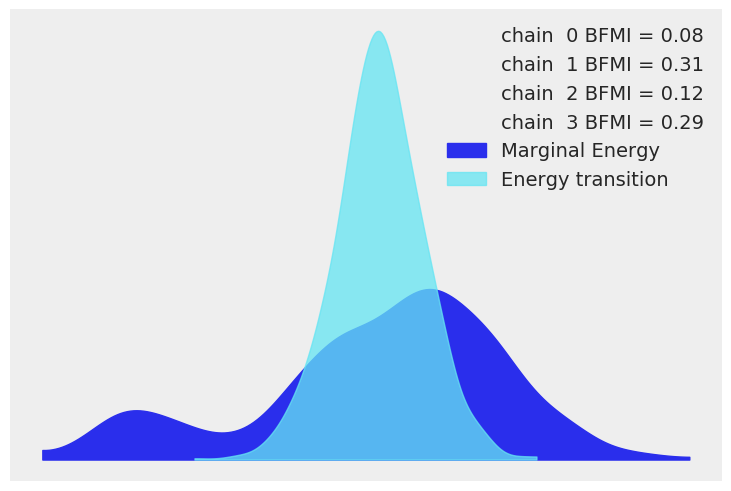

In [9]:
plot_energy(idata);

## Environment

In [10]:
using Pkg
Pkg.status()

    Status `~/projects/ArviZ.jl/examples/Project.toml`
  [131c737c] ArviZ v0.2.5 #master (https://github.com/arviz-devs/ArviZ.jl.git)
  [593b3428] CmdStan v6.0.2
  [31c24e10] Distributions v0.21.12
  [7073ff75] IJulia v1.21.1
  [d9ec5142] NamedTupleTools v0.12.1
  [8ce77f84] Soss v0.10.0
  [fce5fe82] Turing v0.8.2


In [11]:
versioninfo()

Julia Version 1.3.1
Commit 2d5741174c (2019-12-30 21:36 UTC)
Platform Info:
  OS: macOS (x86_64-apple-darwin18.6.0)
  CPU: Intel(R) Core(TM) i7-4870HQ CPU @ 2.50GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-6.0.1 (ORCJIT, haswell)
Environment:
  JULIA_CMDSTAN_HOME = /Users/saxen/projects/cmdstan-2.18.0


---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*